In [36]:
# %pip install lightgbm
# %pip install shap

import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier, LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.calibration import calibration_curve
import re
from collections import Counter
import itertools
import shap
import matplotlib.pyplot as plt

# Data Clean

In [ ]:
def load_fin_aid_clean():
    raw = pd.read_csv("../../data_files/StudentFinAidSumm.csv", header=None, encoding="latin1")

    header_year = raw.iloc[0]
    header_metric = raw.iloc[1]

    data = raw.iloc[2:].reset_index(drop=True)

    col_names = []
    n_cols = raw.shape[1]

    for j in range(n_cols):
        if j < 3:
            col_names.append(f"level{j+1}")
        else:
            year_label = str(header_year[j])
            metric_label = str(header_metric[j])
            m = re.search(r"(\d{4}-\d{4})", year_label)
            year = m.group(1) if m else year_label

            metric = metric_label.strip()
            col_names.append(f"{year}|{metric}")

    data.columns = col_names

    id_cols = ["level1", "level2", "level3"]
    data[id_cols] = data[id_cols].ffill()
    

    value_cols = [c for c in data.columns if c not in id_cols]

    long = data.melt(
        id_vars=id_cols,
        value_vars=value_cols,
        var_name="year_metric",
        value_name="value",
    )

    long[["year", "metric"]] = long["year_metric"].str.split("|", n=1, expand=True)
    

    tidy = (
        long
        .pivot_table(
            index=id_cols + ["year"],
            columns="metric",
            values="value",
            aggfunc="first",
        )
        .reset_index()
    )

    tidy.columns.name = None

    if "Aid Amount" in tidy.columns:
        tidy["Aid Amount"] = (
            tidy["Aid Amount"]
            .astype(str)
            .str.replace(r"[$,]", "", regex=True)
            .replace("nan", pd.NA)
            .astype(float)
        )

    for col in ["Student Count", "Award Count"]:
        if col in tidy.columns:
            tidy[col] = pd.to_numeric(tidy[col], errors="coerce")

    tidy["year"] = tidy["year"].str[:4].astype(int)
    tidy['level2'] = tidy['level2'].apply(lambda x: x[:-6])
    
    return tidy

def load_citizenship_clean():
    raw = pd.read_csv("../../data_files/StudentCitizenshipStatus.csv", header=None, encoding="latin1")

    header_term = raw.iloc[0]
    header_metric = raw.iloc[1]

    data = raw.iloc[2:].reset_index(drop=True)

    col_names = []
    n_cols = raw.shape[1]

    for j in range(n_cols):
        if j == 0:
            col_names.append("level1")
        elif j == 1:
            col_names.append("level2")
        else:
            term = str(header_term[j]).strip()
            metric = str(header_metric[j]).strip()
            col_names.append(f"{term}|{metric}")

    data.columns = col_names

    data[["level1", "level2"]] = data[["level1", "level2"]].ffill()

    value_cols = [c for c in data.columns if c not in ["level1", "level2"]]

    long = data.melt(
        id_vars=["level1", "level2"],
        value_vars=value_cols,
        var_name="term_metric",
        value_name="value",
    )

    long[["term", "metric"]] = long["term_metric"].str.split("|", n=1, expand=True)

    tidy = (
        long
        .pivot_table(
            index=["level1", "level2", "term"],
            columns="metric",
            values="value",
            aggfunc="first",
        )
        .reset_index()
    )

    tidy.columns.name = None

    if "Student Count" in tidy.columns:
        tidy["Student Count"] = (
            tidy["Student Count"]
            .astype(str)
            .str.replace(",", "", regex=False)
            .replace("nan", np.nan)
            .astype(float)
        )

    if "Student Count (%)" in tidy.columns:
        tidy["Student Count (%)"] = (
            pd.to_numeric(
                tidy["Student Count (%)"]
                .astype(str)
                .str.rstrip("%"),
                errors="coerce",
            ) / 100.0
        )

    tidy["year"] = tidy["term"].str[-4:].astype(int)

    return tidy


cc_scorecard = pd.read_csv("../../data_files/cc_scorecard.csv")
uc_scorecard = pd.read_csv("../../data_files/uc_scorecard.csv")

cc2uc_major = pd.read_csv("../../data_files/cc2uc_major.csv")
cc2uc_eth = pd.read_csv("../../data_files/cc2uc_3status_eth.csv")
cc2uc_gnd = pd.read_csv("../../data_files/cc2uc_3status_gnd.csv")

fin_aid = load_fin_aid_clean()
citizen = load_citizenship_clean()

dist = pd.read_csv("../../data_files/cc_uc_drive_distances.csv")


In [38]:
# Normalize columns
def normalize_cols(df):
    df = df.copy()
    df.columns = [c.strip().lower() for c in df.columns]
    return df

cc_scorecard = normalize_cols(cc_scorecard)
uc_scorecard = normalize_cols(uc_scorecard)
cc2uc_major = normalize_cols(cc2uc_major)
cc2uc_eth = normalize_cols(cc2uc_eth)
cc2uc_gnd = normalize_cols(cc2uc_gnd)
fin_aid = normalize_cols(fin_aid)
citizen = normalize_cols(citizen)
dist = normalize_cols(dist)

In [39]:
# UC & year normalization
uc_name_mapping = {
    "UCB" : "Berkeley",
    "UCD" : "Davis",
    "UCLA" : "Los Angeles",
    "UCSD" : "San Diego",
    "UCI" : "Irvine",
    "UCSB" : "Santa Barbara",
    "UCSC" : "Santa Cruz",
    "UCM" : "Merced",
    "UCR" : "Riverside"
}
uc_scorecard = uc_scorecard.rename(columns={"school.name": "uc"})
uc_scorecard['uc'] = uc_scorecard['uc'].apply(lambda x: x[25:])
cc2uc_major["uc"] = cc2uc_major["uc"].map(uc_name_mapping)
dist = dist.rename(columns={"uc_name" : "uc"})
dist['uc'] = dist['uc'].apply(lambda x: x[25:])

cc2uc_major['year'] = cc2uc_major['year'].apply(lambda x: int(x[:4]))
cc2uc_eth['year'] = cc2uc_eth['year'].apply(lambda x: int(x[:4]))
cc2uc_gnd['year'] = cc2uc_gnd['year'].apply(lambda x: int(x[:4]))

In [40]:
# CC normalization
def normalize_cc_name(name: str) -> str:
    if pd.isna(name):
        return ""
    s = str(name).upper().strip()

    s = re.sub(r"\s+", " ", s)

    s = s.replace("MT.", "MOUNT").replace("MT ", "MOUNT ")
    s = s.replace(" ST.", " SAINT").replace(" ST ", " SAINT ")
    s = re.sub(r"\b(TOTAL|DISTRICT)\b", "", s)
    s = re.sub(r"^(CITY\s+COLLEGE|COLLEGE)\s+OF\s+", "", s)
    s = re.sub(r"\bCOMMUNITY COLLEGE\b", "", s)
    s = re.sub(r"\bCOLLEGE\b", "", s)
    s = re.sub(r"^THE\s+", "", s)
    s = re.sub(r"[^A-Z0-9 ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()

    return s

cc2uc_major = cc2uc_major.rename(columns={"cc": "school"})
cc2uc_major["cc"] = cc2uc_major["school"].apply(normalize_cc_name)
cc2uc_eth["cc"] = cc2uc_eth["school"].apply(normalize_cc_name)
cc2uc_gnd["cc"] = cc2uc_gnd["school"].apply(normalize_cc_name)
cc_scorecard["cc"] = cc_scorecard["school.name"].apply(normalize_cc_name)
fin_aid["cc"] = fin_aid["level1"].apply(normalize_cc_name)
citizen["cc"] = citizen["level1"].apply(normalize_cc_name)
dist["cc"] = dist["cc_name"].apply(normalize_cc_name)


In [41]:
#Change type to numeric
def num_normalize(col):
    s = (
        col.astype(str)
        .str.replace(",", "", regex=False)
        .str.replace(r"[^\d\.\-]", "", regex=True)
    )
    return pd.to_numeric(s, errors="coerce")

cc2uc_major = cc2uc_major.rename(columns={"enrolls": "num"})
cc2uc_major["num"] = num_normalize(cc2uc_major["num"])
cc2uc_eth["num"] = num_normalize(cc2uc_eth["num"])
cc2uc_gnd["num"] = num_normalize(cc2uc_gnd["num"])

In [42]:
# Choose 2012-2023 data
YEAR_MIN, YEAR_MAX = 2012, 2023

def year_filter(df, col="year"):
    return df[(df[col] >= YEAR_MIN) & (df[col] <= YEAR_MAX)]

cc_scorecard = year_filter(cc_scorecard)
uc_scorecard = year_filter(uc_scorecard)
cc2uc_major = year_filter(cc2uc_major)
cc2uc_eth = year_filter(cc2uc_eth)
cc2uc_gnd = year_filter(cc2uc_gnd)
fin_aid = year_filter(fin_aid)
citizen = year_filter(citizen)


# Feature Selection

In [43]:
# Admission rate
cc2uc_app = cc2uc_gnd[(cc2uc_gnd['gender'] == 'All') & (cc2uc_gnd['count'] == 'App')].drop(columns=["gender",'count'])
cc2uc_adm = cc2uc_gnd[(cc2uc_gnd['gender'] == 'All') & (cc2uc_gnd['count'] == 'Adm')].drop(columns=["gender",'count'])
base = pd.merge(cc2uc_app,cc2uc_adm,on=["year","cc","city","county","school",'uc'],suffixes=['_app','_adm'])
base['adm_rate'] = base['num_adm']/base['num_app']
base.head()

,city,county,school,uc,year,num_app,cc,num_adm,adm_rate
0,Santa Maria,Santa Barbara,ALLAN HANCOCK COLLEGE,Berkeley,2012,48.0,ALLAN HANCOCK,7.0,0.145833
1,Sacramento,Sacramento,AMERICAN RIVER COLLEGE,Berkeley,2012,170.0,AMERICAN RIVER,50.0,0.294118
2,Lancaster,Los Angeles,ANTELOPE VALLEY COLLEGE,Berkeley,2012,33.0,ANTELOPE VALLEY,10.0,0.303030
3,Bakersfield,Kern,BAKERSFIELD COLLEGE,Berkeley,2012,39.0,BAKERSFIELD,4.0,0.102564
4,Barstow,San Bernardino,BARSTOW COMMUNITY COLLEGE,Berkeley,2012,5.0,BARSTOW,0.0,0.000000


In [ ]:
# CC/UC scorecard

data_dic = pd.read_csv("../../data_files/Data Dictionary - STA221.csv")
data_dic = normalize_cols(data_dic)

mask_q1 = (data_dic["q1"] == True) & (data_dic["source"].str.contains("scorecard"))
q1_scorecard_cols = data_dic.loc[mask_q1, "feature"].tolist()

cc_feat = cc_scorecard[["cc"] + q1_scorecard_cols].copy()
uc_feat = uc_scorecard[["uc"] + q1_scorecard_cols].copy()

cc_feat = cc_feat.add_prefix("cc_")
uc_feat = uc_feat.add_prefix("uc_")

cc_feat = cc_feat.rename(columns={"cc_year": "year", "cc_cc": "cc"})
uc_feat = uc_feat.rename(columns={"uc_year": "year", "uc_uc": "uc"})

cc_feat.head()


,cc,year,cc_aid.ftft_pell_grant_rate,cc_aid.ftft_federal_loan_rate,cc_aid.pell_grant_rate,cc_aid.federal_loan_rate,cc_aid.loan_principal,cc_aid.median_debt.pell_grant,cc_aid.median_debt.no_pell_grant,cc_aid.median_debt.first_generation_students,...,cc_student.demographics.faculty.race_ethnicity.black,cc_student.demographics.faculty.race_ethnicity.hispanic,cc_student.demographics.faculty.race_ethnicity.nhpi,cc_student.demographics.faculty.race_ethnicity.non_resident_alien,cc_student.demographics.faculty.race_ethnicity.unknown,cc_student.demographics.faculty.race_ethnicity.white,cc_student.demographics.faculty.men,cc_student.demographics.faculty.women,cc_student.enrollment.undergrad_12_month,cc_admissions.admission_rate.overall
0,CUYAMACA,2012.0,0.4523,0.0098,0.2902,0.0244,3500.0,3500.0,4500.0,3500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13109.0,NaN
1,GROSSMONT,2012.0,0.3899,0.0450,0.2348,0.0304,3234.0,3209.5,3500.0,2826.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25714.0,NaN
2,IMPERIAL VALLEY,2012.0,0.7614,0.0000,0.5777,0.0000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9820.0,NaN
3,MIRACOSTA,2012.0,0.2165,0.0184,0.0985,0.0125,3500.0,3500.0,3500.0,3500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21722.0,NaN
4,PALOMAR,2012.0,0.3291,0.0198,0.1508,0.0146,3840.0,4474.0,3500.0,4096.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35407.0,NaN


In [45]:
# Majors

# 115 majors are too many, we aggregate them as subfield
FIELD_GROUPS = {
    "life_sciences": [
        "Biology, General",
        "Biochemistry, Biophysics and Molecular Biology",
        "Genetics",
        "Neurobiology and Neurosciences",
        "Zoology/Animal Biology",
        "Cell/Cellular Biology and Anatomical Sciences",
        "Microbiological Sciences and Immunology",
        "Biotechnology",
        "Physiology, Pathology and Related Sciences",
        "Ecology, Evolution, Systematics, and Population Biology",
        "Pharmacology and Toxicology",
        "Botany/Plant Biology",
        "Biomathematics, Bioinformatics, and Computational Biology",
    ],
    "communication_media": [
        "Communication and Media Studies",
        "Journalism",
    ],
    "english_literature": [
        "English Language and Literature, General",
        "Rhetoric and Composition/Writing Studies",
        "Literature",
        "English Language and Literature/Letters, Other",
    ],
    "languages_linguistics": [
        "Linguistic, Comparative, and Related Language Studies and Services",
        "Romance Languages, Literatures, and Linguistics",
        "Foreign Languages, Literatures, and Linguistics, Other",
        "East Asian Languages, Literatures, and Linguistics",
        "Middle/Near Eastern and Semitic Languages, Literatures, and Linguistics",
    ],
    "psychology": [
        "Psychology, General",
        "Research and Experimental Psychology",
        "Clinical, Counseling and Applied Psychology",
        "Psychology, Other",
    ],
    "social_sciences": [
        "Economics",
        "Sociology",
        "Political Science and Government",
        "Anthropology",
        "International Relations and National Security Studies",
        "Social Sciences, Other",
        "Criminology",
        "Geography and Cartography",
        "Urban Studies/Affairs",
    ],
    "engineering": [
        "Biomedical/Medical Engineering",
        "Chemical Engineering",
        "Engineering, General",
        "Computer Engineering",
        "Mechanical Engineering",
        "Civil Engineering",
        "Electrical, Electronics, and Communications Engineering",
        "Aerospace, Aeronautical, and Astronautical/Space Engineering",
        "Engineering, Other",
        "Operations Research",
        "Environmental/Environmental Health Engineering",
        "Materials Engineering",
    ],
    "visual_performing_arts": [
        "Film/Video and Photographic Arts",
        "Design and Applied Arts",
        "Drama/Theatre Arts and Stagecraft",
        "Fine and Studio Arts",
        "Music",
        "Visual and Performing Arts, General",
        "Dance",
    ],
    "interdisciplinary": [
        "International/Globalization Studies",
        "Multi/Interdisciplinary Studies, Other",
        "Nutrition Sciences",
        "Peace Studies and Conflict Resolution",
        "Cognitive Science",
        "Mathematics and Computer Science",
        "Human Biology",
        "Data Science",
        "Geography and Environmental Studies",
    ],
    "history": [
        "History",
    ],
    "business_management": [
        "Business/Managerial Economics",
        "Business Administration, Management and Operations",
        "Management Sciences and Quantitative Methods",
        "Management Information Systems and Services",
        "Human Resources Management and Services",
    ],
    "human_development": [
        "Human Development, Family Studies, and Related Services",
    ],
    "philosophy_religion": [
        "Philosophy",
        "Religion/Religious Studies",
    ],
    "physical_sciences": [
        "Chemistry",
        "Physics",
        "Astronomy and Astrophysics",
        "Geological and Earth Sciences/Geosciences",
        "Materials Sciences",
    ],
    "computer_science": [
        "Computer Science",
        "Computer and Information Sciences, General",
        "Computer/Information Technology Administration and Management",
        "Information Science/Studies",
        "Computer Programming",
        "Computer Software and Media Applications",
    ],
    "health_professions": [
        "Pharmacy, Pharmaceutical Sciences, and Administration",
        "Public Health",
        "Registered Nursing, Nursing Administration, Nursing Research and Clinical",
    ],
    "math_statistics": [
        "Mathematics",
        "Statistics",
        "Applied Mathematics",
    ],
    "natural_resources": [
        "Natural Resources Conservation and Research",
        "Natural Resources and Conservation, Other",
        "Wildlife and Wildlands Science and Management",
    ],
    "agriculture": [
        "Food Science and Technology",
        "Animal Sciences",
        "Agriculture, General",
        "Agricultural Production Operations",
        "Plant Sciences",
    ],
    "planning_architecture": [
        "City/Urban, Community, and Regional Planning",
        "Landscape Architecture",
        "Architecture",
        "Environmental Design",
        "Real Estate Development",
    ],
    "education": [
        "Teacher Education and Professional Development, Specific Subject Areas",
        "Social and Philosophical Foundations of Education",
        "Education, General",
    ],
    "area_ethnic_gender_studies": [
        "Area Studies",
        "Ethnic, Cultural Minority, Gender, and Group Studies",
    ],
    "social_work_public_service": [
        "Social Work",
        "Community Organization and Advocacy",
        "Public Policy Analysis",
        "Public Administration",
    ],
    "legal_studies": [
        "Non-Professional Legal Studies",
    ],
    "liberal_arts": [
        "Liberal Arts and Sciences, General Studies and Humanities",
    ],
}

MAJOR_TO_SUBFIELD = {
    major: subfield
    for subfield, majors in FIELD_GROUPS.items()
    for major in majors
}

# subfield -> STEM/Non-STEM
SUBFIELD_TO_FIELD_BIG = {

    "life_sciences": "STEM",
    "engineering": "STEM",
    "physical_sciences": "STEM",
    "computer_science": "STEM",
    "math_statistics": "STEM",
    "natural_resources": "STEM",
    "agriculture": "STEM",
    "planning_architecture": "STEM", 

    "business_management": "Business",

    "social_sciences": "SocialScience",
    "psychology": "SocialScience",
    "human_development": "SocialScience",
    "social_work_public_service": "SocialScience",
    "legal_studies": "SocialScience",

    "english_literature": "Humanities",
    "languages_linguistics": "Humanities",
    "history": "Humanities",
    "philosophy_religion": "Humanities",
    "area_ethnic_gender_studies": "Humanities",
    "liberal_arts": "Humanities",
    "visual_performing_arts": "Arts",

    "education": "Education",

    "health_professions": "Health",

    "interdisciplinary": "Interdisciplinary",
    "communication_media": "Interdisciplinary",
}

STEM_SUBFIELDS = {
    "life_sciences",
    "engineering",
    "physical_sciences",
    "computer_science",
    "math_statistics",
    "natural_resources",
    "agriculture",
    "planning_architecture",
    "health_professions",   
    "interdisciplinary",      
}


def major_to_subfield(major_name: str) -> str:
    name = str(major_name).strip()
    return MAJOR_TO_SUBFIELD.get(name)

def major_to_stem_flag(major_name: str) -> int:
    subfield = major_to_subfield(major_name)
    return 1 if subfield in STEM_SUBFIELDS else 0


maj = cc2uc_major.copy()

maj["subfield"] = maj["major"].apply(major_to_subfield)
maj["is_stem"] = maj["major"].apply(major_to_stem_flag)

maj["stem_num"] = maj["is_stem"] * maj["num"]

base_sf = (
    maj.groupby(["year", "cc", "uc"], as_index=False)
          .agg(
              total_students=("num", "sum"),
              stem_students=("stem_num", "sum"),
          )
)

base_sf["stem_pct"] = base_sf["stem_students"] / base_sf["total_students"].replace(0, np.nan)

sf_group = (
    maj.groupby(["year", "cc", "uc", "subfield"], as_index=False)["num"]
          .sum()
)

sf_pivot = (
    sf_group
    .pivot_table(
        index=["year", "cc", "uc"],
        columns="subfield",
        values="num",
        aggfunc="first",
    )
    .reset_index()
)
sf_pivot.columns.name = None

sub_cols = [c for c in sf_pivot.columns if c not in ["year", "cc", "uc"]]
for c in sub_cols:
    sf_pivot[c] = sf_pivot[c].fillna(0)

sf_pivot = sf_pivot.merge(base_sf, on=["year", "cc", "uc"], how="left")

for c in sub_cols:
    new_col = f"subfield_pct_{c}"
    sf_pivot[new_col] = sf_pivot[c] / sf_pivot["total_students"].replace(0, np.nan)

major_feat = sf_pivot[
    ["year", "cc", "uc",
     "total_students", "stem_students", "stem_pct"] +
    [c for c in sf_pivot.columns if c.startswith("subfield_pct_")]
].copy()

major_feat.head()

,year,cc,uc,total_students,stem_students,stem_pct,subfield_pct_agriculture,subfield_pct_area_ethnic_gender_studies,subfield_pct_business_management,subfield_pct_communication_media,...,subfield_pct_life_sciences,subfield_pct_math_statistics,subfield_pct_natural_resources,subfield_pct_philosophy_religion,subfield_pct_physical_sciences,subfield_pct_planning_architecture,subfield_pct_psychology,subfield_pct_social_sciences,subfield_pct_social_work_public_service,subfield_pct_visual_performing_arts
0,2012,ALAMEDA,Davis,10,0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.600000,0.400000,0.0,0.0
1,2012,ALLAN HANCOCK,Santa Barbara,22,3,0.136364,0.0,0.0,0.000000,0.136364,...,0.136364,0.0,0.0,0.000000,0.000000,0.0,0.272727,0.318182,0.0,0.0
2,2012,ALLAN HANCOCK,Santa Cruz,6,0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.000000,0.0,0.0
3,2012,AMERICAN RIVER,Berkeley,11,0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.272727,0.000000,0.0,0.000000,0.727273,0.0,0.0
4,2012,AMERICAN RIVER,Davis,95,53,0.557895,0.0,0.0,0.042105,0.031579,...,0.410526,0.0,0.0,0.000000,0.073684,0.0,0.147368,0.115789,0.0,0.0


In [46]:
# Financial aid
fin_grp = fin_aid.groupby(["year", "cc", 'level2'], as_index=False)[['aid amount','student count']].sum()
fin_grp = fin_grp.rename(columns={'level2': 'aid_type'})
fin_grp["aid_per"] = np.where(
    fin_grp["student count"] > 0,
    fin_grp["aid amount"] / fin_grp["student count"],
    np.nan
)

fin_grp["All"] = (
    fin_grp["aid amount"].groupby([fin_grp["year"], fin_grp["cc"]]).transform("sum")
    /
    fin_grp["student count"].groupby([fin_grp["year"], fin_grp["cc"]]).transform("sum")
)


fin_pivot = fin_grp.pivot_table(
    index=["year", "cc"],
    columns="aid_type",
    values="aid_per",
    aggfunc="first"
).reset_index().fillna(0)

fin_total = (
    fin_grp[["year", "cc", "All"]]
    .drop_duplicates()
)

fin_pivot = fin_pivot.merge(fin_total, on=["year", "cc"], how="left")

fin_cols = [c for c in fin_pivot.columns if c not in ["year", "cc", "uc"]]

for c in fin_cols:
    col_name = str(c).lower().strip()
    col_name = col_name.replace(" ", "_")
    share_col = f"fin_per_{col_name}"
    fin_pivot[share_col] = fin_pivot[c]

fin_feat = fin_pivot[
    ["year", "cc"] +
    [c for c in fin_pivot.columns if c.startswith("fin_per_")]
].copy()

fin_feat.head()

,year,cc,fin_per_california_college_promise_grant,fin_per_grants,fin_per_loans,fin_per_scholarship,fin_per_work_study,fin_per_all
0,2012,ALAMEDA,4773.547967,14635.340113,4788.428571,1332.185185,2683.905882,8977.832649
1,2012,ALLAN HANCOCK,47193.776952,18521.076278,4472.461942,1436.491803,241735.939759,18173.891258
2,2012,AMERICAN RIVER,106827.801858,213127.689751,397345.382716,1143.344697,158785.946695,124122.444381
3,2012,ANTELOPE VALLEY,101227.502646,51107.233788,0.000000,927.620053,268527.904545,89473.657653
4,2012,BAKERSFIELD,730238.733333,185547.898649,3988.784593,2526.086957,0.000000,51717.547879


In [47]:
# Citizenship
citizen_pivot = citizen.pivot_table(
    index=["year", "cc"],
    columns="level2",
    values="student count (%)",
    aggfunc="first"
).reset_index().fillna(0)

citizen_cols = [c for c in citizen_pivot.columns if c not in ["year", "cc", "uc"]]

for c in citizen_cols:
    col_name = str(c).lower().strip()
    col_name = col_name.replace(" ", "_")
    share_col = f"citizen_pct_{col_name}"
    citizen_pivot[share_col] = citizen_pivot[c]

citizen_feat = citizen_pivot[
    ["year", "cc"] +
    [c for c in citizen_pivot.columns if c.startswith("citizen_pct_")]
].copy()

citizen_feat.head()


level2,year,cc,citizen_pct_other_status,citizen_pct_permanent_resident,citizen_pct_refugee_/_asylee,citizen_pct_status_unknown_/_uncollected,citizen_pct_student_visa_(f-1_or_m-1_visa),citizen_pct_temporary_resident,citizen_pct_u.s._citizen
0,2012,ALAMEDA,0.0000,0.1539,0.0000,0.0831,0.0366,0.0148,0.7116
1,2012,ALLAN HANCOCK,0.0673,0.0639,0.0001,0.0916,0.0013,0.0031,0.0094
2,2012,AMERICAN RIVER,0.0166,0.1001,0.0183,0.0025,0.0055,0.0042,0.0188
3,2012,ANTELOPE VALLEY,0.0199,0.0373,0.0004,0.0011,0.0016,0.0018,0.0084
4,2012,BAKERSFIELD,0.0297,0.0517,0.0000,0.0672,0.0014,0.0002,0.0104


In [48]:
# Gender
gnd_pivot = cc2uc_gnd[cc2uc_gnd['count'] == 'App'].pivot_table(
    index=["year", "cc","uc"],
    columns="gender",
    values="num",
    aggfunc="sum"
).reset_index().fillna(0)

gnd_pivot.columns.name = None

gnd_cols = [c for c in gnd_pivot.columns if c not in ["year", "cc", "uc"]]

for c in gnd_cols:
    col_name = str(c).lower().strip()
    col_name = col_name.replace(" ", "_")
    share_col = f"gnd_pct_{col_name}"
    gnd_pivot[share_col] = gnd_pivot[c] / gnd_pivot["All"].replace(0, np.nan)

gnd_feat = gnd_pivot[
    ["year", "cc", "uc", "All"] +
    [c for c in gnd_pivot.columns if c.startswith("gnd_pct_")]
].copy().drop(columns='gnd_pct_all')

gnd_feat.head()

,year,cc,uc,All,gnd_pct_female,gnd_pct_male,gnd_pct_other,gnd_pct_unknown
0,2012,ALAMEDA,Berkeley,67.0,0.462687,0.537313,0.0,0.0
1,2012,ALAMEDA,Davis,53.0,0.509434,0.490566,0.0,0.0
2,2012,ALAMEDA,Irvine,41.0,0.365854,0.634146,0.0,0.0
3,2012,ALAMEDA,Los Angeles,40.0,0.475000,0.525000,0.0,0.0
4,2012,ALAMEDA,Merced,11.0,0.545455,0.454545,0.0,0.0


In [49]:
# Ethnicity
eth_pivot = cc2uc_eth[cc2uc_eth['count'] == 'App'].pivot_table(
    index=["year", "cc","uc"],
    columns="ethnicity",
    values="num",
    aggfunc="sum"
).reset_index().fillna(0)

eth_pivot.columns.name = None

eth_cols = [c for c in eth_pivot.columns if c not in ["year", "cc", "uc"]]

for c in eth_cols:
    col_name = str(c).lower().strip()
    col_name = col_name.replace(" ", "_")
    share_col = f"eth_pct_{col_name}"
    eth_pivot[share_col] = eth_pivot[c] / eth_pivot["All"].replace(0, np.nan)

eth_feat = eth_pivot[
    ["year", "cc", "uc", "All"] +
    [c for c in eth_pivot.columns if c.startswith("eth_pct_")]
].copy().drop(columns='eth_pct_all')

eth_feat.head()

,year,cc,uc,All,eth_pct_african_american,eth_pct_american_indian,eth_pct_asian,eth_pct_domestic_unknown,eth_pct_hispanic/_latinx,eth_pct_int'l,eth_pct_pacific_islander,eth_pct_white
0,2012,ALAMEDA,Berkeley,67.0,0.179104,0.0,0.432836,0.089552,0.134328,0.0,0.0,0.134328
1,2012,ALAMEDA,Davis,56.0,0.107143,0.0,0.589286,0.089286,0.089286,0.0,0.0,0.107143
2,2012,ALAMEDA,Irvine,44.0,0.000000,0.0,0.704545,0.113636,0.000000,0.0,0.0,0.000000
3,2012,ALAMEDA,Los Angeles,43.0,0.162791,0.0,0.511628,0.116279,0.116279,0.0,0.0,0.000000
4,2012,ALAMEDA,Merced,11.0,0.000000,0.0,0.727273,0.000000,0.000000,0.0,0.0,0.000000


In [50]:
# Distance
dist_feat = dist[["cc", "uc", "distance_miles"]]
dist_feat.head()

,cc,uc,distance_miles
0,ALLAN HANCOCK,Berkeley,264.32
1,ALLAN HANCOCK,Davis,317.68
2,ALLAN HANCOCK,Irvine,198.49
3,ALLAN HANCOCK,Los Angeles,162.75
4,ALLAN HANCOCK,Merced,230.16


In [51]:
# Data merge
df = base.merge(cc_feat, on=["year", "cc"], how="left")
# df = df.merge(uc_feat, on=["year", "uc"], how="left")
df = df.merge(major_feat, on=["year", "cc", "uc"], how="left")
df = df.merge(fin_feat, on=["year", "cc"], how="left")
df = df.merge(citizen_feat, on=["year", "cc"], how="left")
df = df.merge(gnd_feat, on=["year", "cc", "uc"], how="left")
df = df.merge(eth_feat, on=["year", "cc", "uc"], how="left")
df = df.merge(dist_feat, on=["cc", "uc"], how="left")

df.head()

,city,county,school,uc,year,num_app,cc,num_adm,adm_rate,cc_aid.ftft_pell_grant_rate,...,All_y,eth_pct_african_american,eth_pct_american_indian,eth_pct_asian,eth_pct_domestic_unknown,eth_pct_hispanic/_latinx,eth_pct_int'l,eth_pct_pacific_islander,eth_pct_white,distance_miles
0,Santa Maria,Santa Barbara,ALLAN HANCOCK COLLEGE,Berkeley,2012,48.0,ALLAN HANCOCK,7.0,0.145833,0.5153,...,48.0,0.000000,0.0,0.125000,0.000000,0.500000,0.000000,0.0,0.333333,264.32
1,Sacramento,Sacramento,AMERICAN RIVER COLLEGE,Berkeley,2012,170.0,AMERICAN RIVER,50.0,0.294118,0.5695,...,171.0,0.040936,0.0,0.245614,0.081871,0.116959,0.052632,0.0,0.438596,89.16
2,Lancaster,Los Angeles,ANTELOPE VALLEY COLLEGE,Berkeley,2012,33.0,ANTELOPE VALLEY,10.0,0.303030,0.6454,...,33.0,0.000000,0.0,0.000000,0.000000,0.454545,0.000000,0.0,0.272727,353.26
3,Bakersfield,Kern,BAKERSFIELD COLLEGE,Berkeley,2012,39.0,BAKERSFIELD,4.0,0.102564,0.6061,...,39.0,0.000000,0.0,0.128205,0.000000,0.333333,0.000000,0.0,0.333333,277.33
4,Barstow,San Bernardino,BARSTOW COMMUNITY COLLEGE,Berkeley,2012,5.0,BARSTOW,0.0,0.000000,0.7633,...,5.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,406.21


# Benchmark

In [52]:
df_bm = df.copy()

def compute_benchmark(df):
    df = df.sort_values("year")
    benchmarks = []
    for i in range(len(df)):
        past = df.iloc[:i]
        if len(past) == 0:
            benchmarks.append(np.nan)
        else:
            benchmarks.append(past["adm_rate"].median())
    df["bm_past_median"] = benchmarks
    return df

df_bm = df_bm.groupby(["cc", "uc"], group_keys=False).apply(compute_benchmark)
df_bm = df_bm.dropna(subset=["bm_past_median"])

df_bm["benchmark"] = (df_bm["adm_rate"] > df_bm["bm_past_median"]).astype(int)

df_bm = df_bm.copy()

df_bm["covid_type"] = df_bm["year"].apply(lambda x: 0 if x <= 2019 else (1 if x <= 2021 else 2))    

years = sorted(df_bm["year"].unique())
df_bm["year_centered"] = df_bm["year"] - years[0]
    
df_bm.head()

d:\Python\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
d:\Python\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
d:\Python\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
d:\Python\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
d:\Python\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
d:\Python\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
d:\Python\lib\site-packages\numpy\lib\_nanfunc

,city,county,school,uc,year,num_app,cc,num_adm,adm_rate,cc_aid.ftft_pell_grant_rate,...,eth_pct_domestic_unknown,eth_pct_hispanic/_latinx,eth_pct_int'l,eth_pct_pacific_islander,eth_pct_white,distance_miles,bm_past_median,benchmark,covid_type,year_centered
1005,Santa Maria,Santa Barbara,ALLAN HANCOCK COLLEGE,Berkeley,2013,51.0,ALLAN HANCOCK,14.0,0.274510,0.5379,...,0.132075,0.377358,0.000000,0.0,0.283019,264.32,0.145833,1,0,0
1006,Sacramento,Sacramento,AMERICAN RIVER COLLEGE,Berkeley,2013,144.0,AMERICAN RIVER,26.0,0.180556,0.5892,...,0.062500,0.152778,0.041667,0.0,0.458333,89.16,0.294118,0,0,0
1007,Lancaster,Los Angeles,ANTELOPE VALLEY COLLEGE,Berkeley,2013,43.0,ANTELOPE VALLEY,12.0,0.279070,0.6648,...,0.000000,0.302326,0.000000,0.0,0.255814,353.26,0.303030,0,0,0
1008,Bakersfield,Kern,BAKERSFIELD COLLEGE,Berkeley,2013,35.0,BAKERSFIELD,13.0,0.371429,0.5546,...,0.000000,0.571429,0.000000,0.0,0.285714,277.33,0.102564,1,0,0
1009,Barstow,San Bernardino,BARSTOW COMMUNITY COLLEGE,Berkeley,2013,6.0,BARSTOW,3.0,0.500000,0.7229,...,0.000000,0.000000,0.000000,0.0,0.000000,406.21,0.000000,1,0,0


# Split Train/Valid/Test Set

In [53]:
train_years = years[:7]     # 2013–2019
valid_years = years[7:9]    # 2020–2021
test_years  = years[9:]     # 2022–2023

train = df_bm[df_bm["year"].isin(train_years)]
valid = df_bm[df_bm["year"].isin(valid_years)]
test  = df_bm[df_bm["year"].isin(test_years)]

exclude = [
    "benchmark", "adm_rate", "bm_past_median",
    "num_app", "num_adm", "school", "city", "county", "year",
    'All_x', 'All_y', 'cc', 'uc'
]

feature_cols = [c for c in df_bm.columns if c not in exclude]

X_train = train[feature_cols]
y_train = train["benchmark"]

X_valid = valid[feature_cols]
y_valid = valid["benchmark"]

X_test = test[feature_cols]
y_test = test["benchmark"]

# Model Building

In [ ]:
def generate_metrics(name, y_true, y_prob, y_pred, majority_label):

    metrics = {"split": name}
    metrics[f"{name}_auc"] = roc_auc_score(y_true, y_prob)

    metrics[f"{name}_acc"] = accuracy_score(y_true, y_pred)
    metrics[f"{name}_f1"]  = f1_score(y_true, y_pred, zero_division=0)

    # majority baseline (always predict the majority of samples)
    y_major = np.full_like(y_true, majority_label)
    metrics[f"{name}_acc_major"] = accuracy_score(y_true, y_major)
    
    return metrics

def lightgbm_training(X_train, y_train,X_valid, y_valid,
                    learning_rate=0.05, num_leaves=30, max_depth=-1, subsample=0.8,
                    colsample_bytree=0.8, lambda_l2=0, stopping_rounds=200, n_estimators=3000):  
    
    majority_label = Counter(y_train).most_common(1)[0][0]

    model = LGBMClassifier(
        learning_rate=learning_rate, #each tree's contribution, high->overfit, low->slow & need more n_estimators
        max_depth=max_depth, #complexity, -1 means no constraints
        num_leaves=num_leaves, #complexity, maximum of leaves, high->overfit, low->underfit
        n_estimators=n_estimators, # num of trees, high->overfit (controlled by early_stopping), low->underfit
        subsample=subsample, #bagging_fraction, sample on data (rows), high->overfit, low->more randomness & high variance
        colsample_bytree=colsample_bytree, #feature_fraction, sample on features(columns), high->better fit but may stick on certain combinations, low->prevent overfitting
        random_state=221,
        lambda_l2=lambda_l2, # l2-regularization
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            early_stopping(stopping_rounds=200),
            log_evaluation(period=100), 
        ]
    )

    prob_train = model.predict_proba(X_train)[:, 1]
    prob_valid = model.predict_proba(X_valid)[:, 1]
    pred_train = (prob_train >= 0.5).astype(int)
    pred_valid = (prob_valid >= 0.5).astype(int)

    m_train = generate_metrics("train", y_train, prob_train, pred_train, majority_label)
    m_valid = generate_metrics("valid", y_valid, prob_valid, pred_valid, majority_label)

    row = {
        "learning_rate": learning_rate,
        "num_leaves": num_leaves,
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "lambda_l2": lambda_l2,
        "stopping_rounds": stopping_rounds,
        "n_estimators": n_estimators,
        "best_iteration": model.best_iteration_
    }
    row.update(m_train)
    row.update(m_valid)

    row["auc_gap_train_valid"] = row["train_auc"] - row["valid_auc"]

    return row, model

learning_rate_list = [0.02, 0.04, 0.06]
num_leaves_list = [40, 60, 90, 120]
lambda_l2_list = [0, 1, 5, 10]
max_depth_list = [-1, 5, 7]

results = []
models = {}

for lr, nl, l2, md in itertools.product(learning_rate_list, num_leaves_list, lambda_l2_list, max_depth_list):
    row, mdl = lightgbm_training(
        X_train, y_train,
        X_valid, y_valid,
        learning_rate=lr,
        num_leaves=nl,
        lambda_l2=l2,
        max_depth=md,
        subsample=0.8,
        colsample_bytree=0.8,
        n_estimators=3000
    )
    results.append(row)
    models[(lr, nl, l2, md)] = mdl

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values("valid_auc", ascending=False)
results_df_sorted.head(10)

[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Info] Number of positive: 3468, number of negative: 3272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16270
[LightGBM] [Info] Number of data points in the train set: 6740, number of used features: 88
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514540 -> initscore=0.058177
[LightGBM] [Info] Start training from score 0.058177
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.680949
[200]	valid_0's binary_logloss: 0.6811
[300]	valid_0's binary_logloss: 0.68396
Early stopping, best iterati

# Model Explaination

In [ ]:
best_row = results_df_sorted.iloc[0]

X_full = pd.concat([X_train, X_valid], axis=0)
y_full = pd.concat([y_train, y_valid], axis=0)

best_params = {
    "learning_rate": float(best_row["learning_rate"]),
    "num_leaves": int(best_row["num_leaves"]),
    "max_depth": int(best_row["max_depth"]),
    "subsample": float(best_row["subsample"]),
    "colsample_bytree": float(best_row["colsample_bytree"]),
    "lambda_l2": float(best_row["lambda_l2"]),
    "n_estimators": int(best_row["best_iteration"]),  # use best_iteration as the maximum of leaves
}

final_model = LGBMClassifier(
    **best_params,
    random_state=221,
    n_jobs=-1,
)

final_model.fit(X_full, y_full)

proba_test = final_model.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

prec, rec, thresh = precision_recall_curve(y_test, proba_test)


prec, rec, thresh = precision_recall_curve(y_test, proba_test)

best_t = None
best_gap = 1e9
best_p = best_r = None

for p, r, t in zip(prec[:-1], rec[:-1], thresh):
    gap = abs(p - r)
    if gap < best_gap:
        best_gap = gap
        best_t = t
        best_p, best_r = p, r


print("AUC: ",roc_auc_score(y_test, proba_test))
print("Threshold with p≈r:", best_t)
print("precision:", best_p, "recall:", best_r)
pred_bal = (proba_test >= best_t).astype(int)
print(classification_report(y_test, pred_bal))

# print(classification_report(y_test, pred_test))



[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Info] Number of positive: 4376, number of negative: 4358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13823
[LightGBM] [Info] Number of data points in the train set: 8734, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501030 -> initscore=0.004122
[LightGBM] [Info] Start training from score 0.004122
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
AUC:  0.5941896993357355
Threshold with p≈r: 0.3739360939396364
precision: 0.6841698841698842 recall: 0.6841698841698842
              precision    recall  f1-score   support

           0    

d:\Python\lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


type(shap_raw): <class 'numpy.ndarray'>
shap_values.shape: (8734, 62)


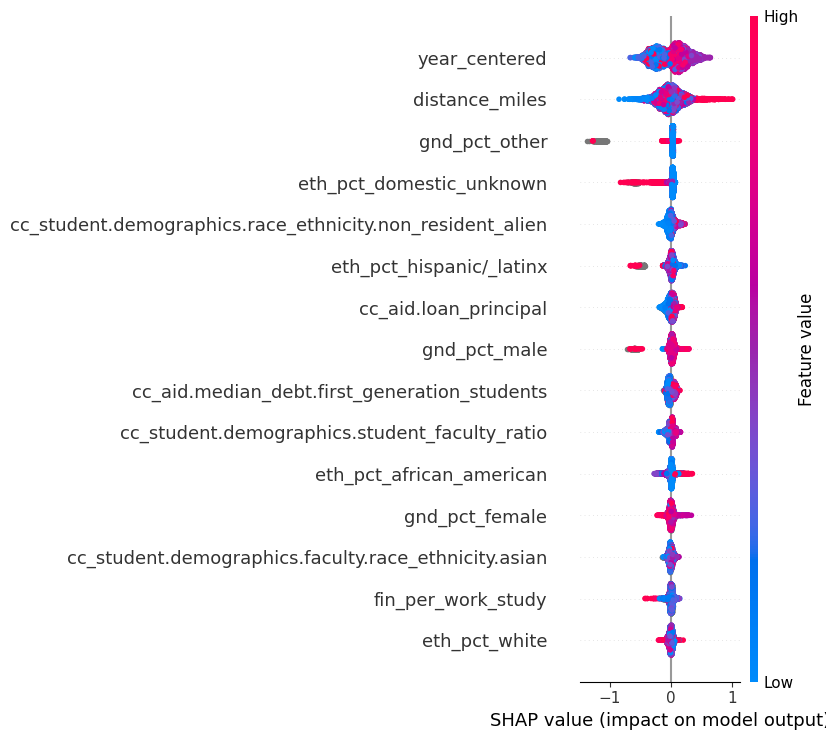

In [ ]:

shap.initjs()

X_explain = X_full 

explainer = shap.TreeExplainer(final_model)
shap_raw = explainer.shap_values(X_explain)

print("type(shap_raw):", type(shap_raw))
if isinstance(shap_raw, list):
    shap_values = shap_raw[1]  
else:
    shap_values = shap_raw

print("shap_values.shape:", shap_values.shape)

shap.summary_plot(
    shap_values,
    X_explain,
    feature_names=feature_cols,
    max_display=15
)



d:\Python\lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


X_for_shap.shape: (8734, 62)
shap_values.shape: (8734, 62)


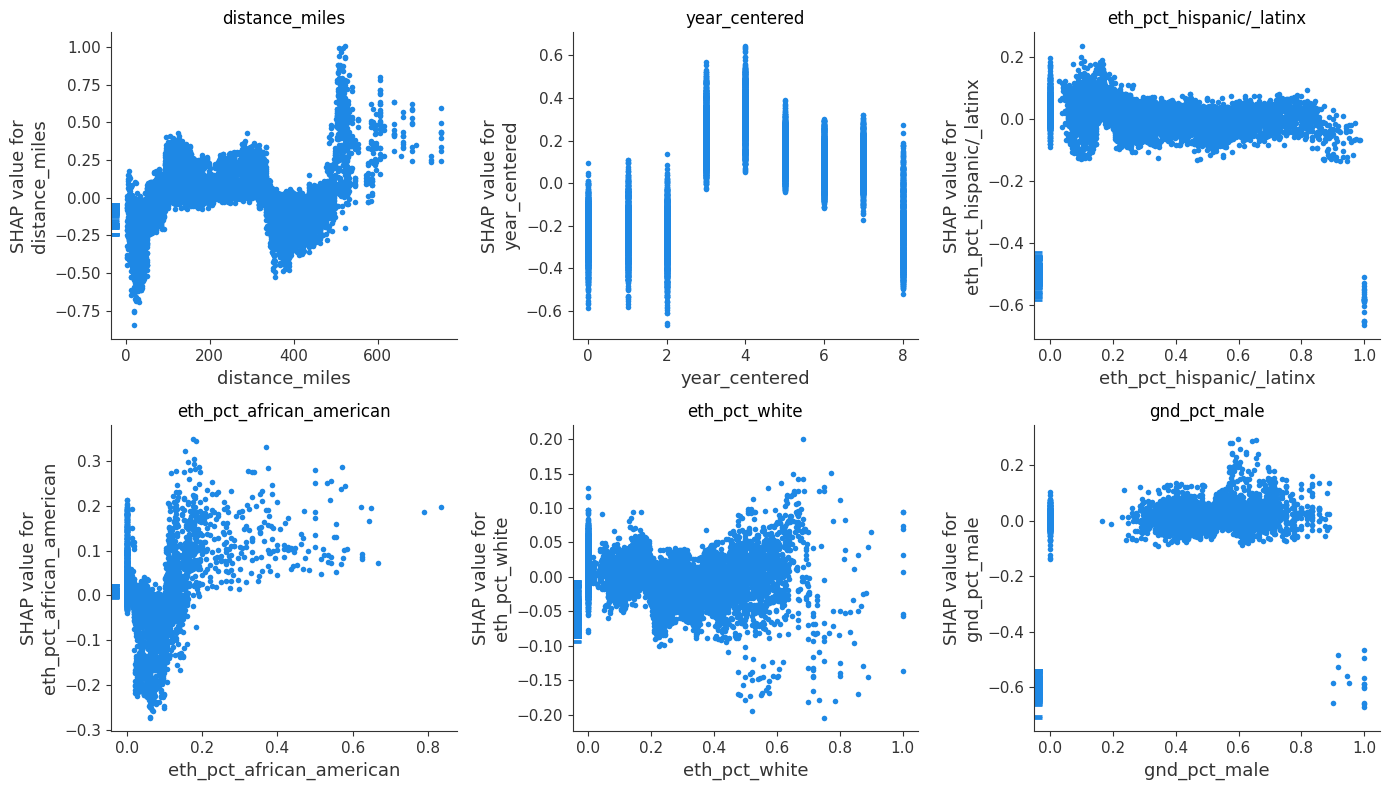

In [ ]:
X_for_shap = X_full.copy()

explainer = shap.TreeExplainer(final_model)
shap_raw = explainer.shap_values(X_for_shap)

if isinstance(shap_raw, list):
    shap_values = shap_raw[1]
else:
    shap_values = shap_raw

if hasattr(shap_values, "values"):
    shap_values = shap_values.values

shap_values = np.asarray(shap_values)

print("X_for_shap.shape:", X_for_shap.shape)
print("shap_values.shape:", shap_values.shape)

assert shap_values.shape[0] == X_for_shap.shape[0]
assert shap_values.shape[1] == X_for_shap.shape[1]

dependence_features = [
    "distance_miles",
    "year_centered",
    "eth_pct_hispanic/_latinx",
    "eth_pct_african_american",
    "eth_pct_white",
    "gnd_pct_male",
]

plt.close('all')


rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(14, 8)) 
axes = axes.ravel()

for ax, f in zip(axes, dependence_features):
    shap.dependence_plot(
        f,
        shap_values,
        X_for_shap,
        display_features=X_for_shap,
        interaction_index=None,
        ax=ax,      
        show=False, 
    )
    ax.set_title(f)

for j in range(len(dependence_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()





num aid features: 15 example: ['cc_aid.ftft_pell_grant_rate', 'cc_aid.ftft_federal_loan_rate', 'cc_aid.pell_grant_rate', 'cc_aid.federal_loan_rate', 'cc_aid.loan_principal']


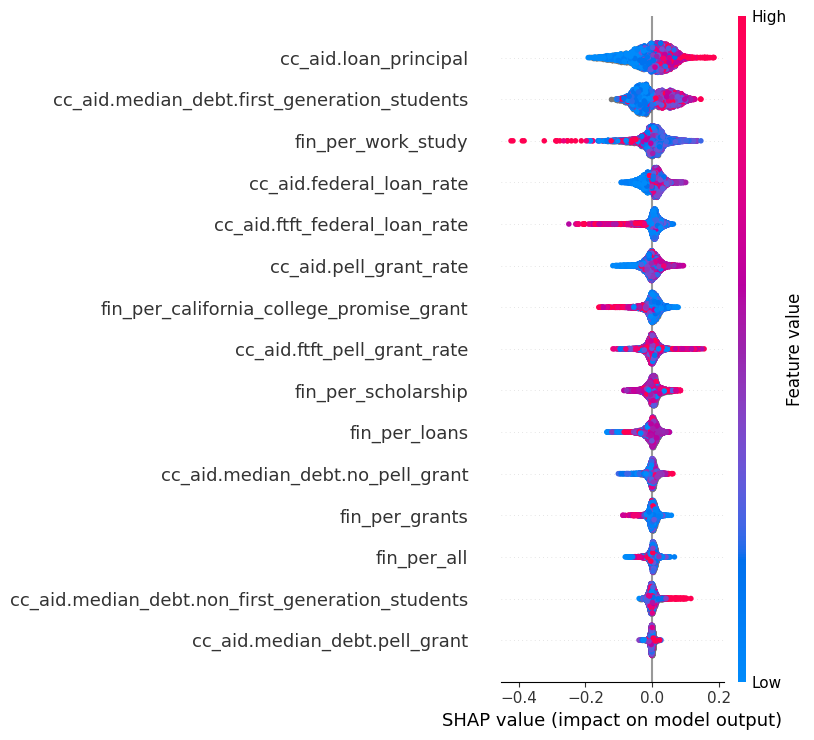

In [ ]:
# Aid
aid_cols = [c for c in feature_cols 
            if c.startswith("fin_per_") or c.startswith("cc_aid.")]
print("num aid features:", len(aid_cols), "example:", aid_cols[:5])

aid_indices = [feature_cols.index(c) for c in aid_cols]

shap.summary_plot(
    shap_values[:, aid_indices],
    X_for_shap[aid_cols],
    feature_names=aid_cols,
    max_display=len(aid_cols),
)